Used Annotations descriptions: [np.str_('1023'), np.str_('1072'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('771'), np.str_('772')]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from data with rank=None
    Using tolerance 0.012 (2.2e-16 eps * 22 dim * 2.5e+12  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using LEDOIT_WOLF
Done.
Estimating class=8 covariance using LEDOIT_WOLF
Done.


<Figure size 1000x400 with 0 Axes>

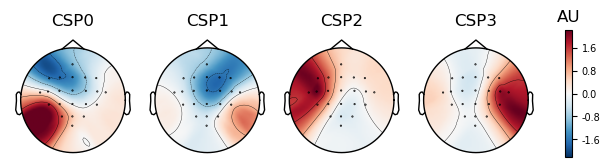

<Figure size 640x480 with 0 Axes>

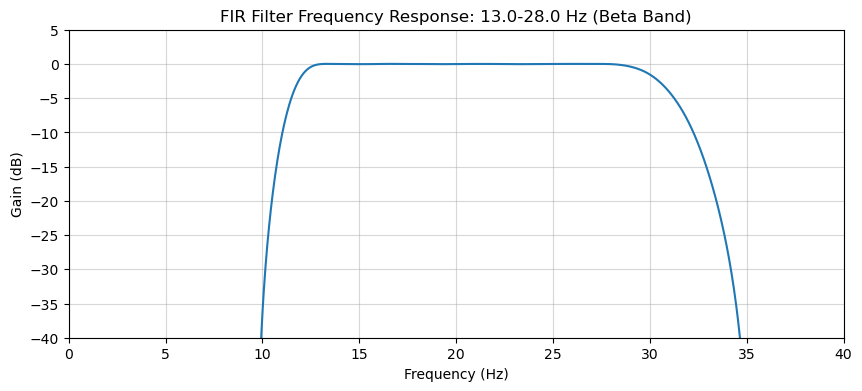

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import mne
from mne.decoding import CSP, FilterEstimator
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from mne.preprocessing import compute_current_source_density
from mne.filter import create_filter 
from scipy.signal import freqz 
import warnings
from mne import set_log_file

# Suppress MNE warnings and log file creation for clean execution
warnings.filterwarnings('ignore', category=RuntimeWarning, module='mne')
set_log_file(None) 

# --- I. DATA LOADING AND PREPROCESSING ---
# NOTE: Replace with the actual path to your GDF file
DATA_PATH_GDF = 'C:/Users/user/Desktop/BCI project/BCICIV_2a_gdf (1)/A01T.gdf' 

# Load raw data and extract events
raw = mne.io.read_raw_gdf(DATA_PATH_GDF, preload=True, verbose=False)
events, event_id = mne.events_from_annotations(raw)
event_id_mi = {
    'Left_hand': event_id['769'], 'Right_hand': event_id['770'], 
    'Foot': event_id['771'], 'Tongue': event_id['772']
}

# Channel and Montage Configuration
eog_names = [ch for ch in raw.ch_names if 'EOG' in ch]
raw.set_channel_types({name: 'eog' for name in eog_names if name in raw.ch_names}, verbose=False)
raw.pick_types(eeg=True, eog=False, exclude=[]) 
standard_names = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']
current_names = raw.ch_names
if len(current_names) == 22:
    mapping = {current_names[i]: standard_names[i] for i in range(len(current_names))}
    raw.rename_channels(mapping)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, on_missing='warn', verbose=False) 

# Apply Current Source Density (CSD)
raw = compute_current_source_density(raw, verbose=False) 
info_topo = raw.info
sfreq = info_topo['sfreq']

# Epoching for Left/Right Hand Motor Imagery
tmin, tmax = -0.5, 3.5 
epochs = mne.Epochs(
    raw, events, event_id_mi, tmin, tmax, 
    proj=True, baseline=(-0.5, 0), preload=True, verbose=False
)
epochs_2_classes = epochs[['Left_hand', 'Right_hand']]
X = epochs_2_classes.get_data() 
y = epochs_2_classes.events[:, 2] 

# --- II. MODEL TRAINING AND OPTIMIZATION PARAMETERS ---
L_FREQ = 13.0
H_FREQ = 28.0
N_COMPONENTS = 4

# Create and train the optimal classifier pipeline
BEST_CLF = Pipeline([
    ('filt', FilterEstimator(raw.info, l_freq=L_FREQ, h_freq=H_FREQ)), 
    ('csp', CSP(n_components=N_COMPONENTS, reg='ledoit_wolf', transform_into='average_power', norm_trace=False)),
    ('classifier', SVC(kernel='linear', C=1, random_state=42))
])

BEST_CLF.fit(X, y) 
csp_best = BEST_CLF.named_steps['csp']

# --- III. RESULTS VISUALIZATION ---

# 3.1 CSP Spatial Patterns
plt.figure(figsize=(10, 4))
csp_best.plot_patterns(info_topo, ch_type='csd', units='AU') 
plt.suptitle('CSP Spatial Patterns (Optimal Components for Motor Imagery)', fontsize=14)
plt.savefig('CSP_Patterns_MI.png', dpi=300, bbox_inches='tight') # SAVE COMMAND
plt.show()

# 3.2 FIR Filter Frequency Response (13-28 Hz)
# Create FIR filter coefficients
h = create_filter(
    data=None, 
    sfreq=sfreq,
    l_freq=L_FREQ,
    h_freq=H_FREQ,
    method='fir',
    fir_design='firwin',
    filter_length='auto',
    verbose=False
)

# Compute frequency response
b = h
a = np.array([1.0])
w, response = freqz(b, a, worN=2**12, fs=sfreq) 

# Plot
plt.figure(figsize=(10, 4))
plt.plot(w, 20 * np.log10(np.abs(response))) # Plotting in dB for clarity
plt.title(f'FIR Filter Frequency Response: {L_FREQ}-{H_FREQ} Hz (Beta Band)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.xlim(0, 40) 
plt.ylim(-40, 5) 
plt.grid(True, alpha=0.5)
plt.savefig('FIR_Response.png', dpi=300, bbox_inches='tight') # SAVE COMMAND
plt.show()